In [1]:
from typing import Optional, Union, Dict
from torch.utils.data import Dataset
import torch
import pandas as pd
from PIL import Image
import numpy as np

class QuIC360Dataset(Dataset):
    def __init__(self, 
                 csv_file: str,
                 model_name: str = "Salesforce/blip2-opt-2.7b",
                 image_size: list = [224,224],
                 max_length: Optional[int] = None,
                 split: str = "train",
                 do_crop: bool = False,
                 patch_size: Optional[tuple] = None,
                 overlap_ratio: Optional[float] = None,
                 fov: Optional[float] = None,
                 transform: bool = False):
        """
        Args:
            csv_file (str): 이미지 경로와 Q&A 정보가 담긴 CSV 파일 경로
            model_name (str): HuggingFace AutoProcessor를 불러올 모델명
            image_size (list): do_crop=False인 경우 Processor가 기대하는 리사이즈 크기 (H, W)
            max_length (int): 텍스트 입력 최대 길이
            split (str): 데이터 분할정보 (train/val 등)
            do_crop (bool): 슬라이딩 윈도우 적용 여부
            patch_size (tuple, optional): 슬라이딩 윈도우 높이/너비(px) (patch_h, patch_w).
                                          fov가 지정되면 patch_w는 fov 기반으로 덮어써진다.
            overlap_ratio (float, optional): 패치 간 겹침 비율 (0.0 ~ 1.0)
            fov (float, optional): “한 패치의 시야각(FOV)”을 도 단위로 지정.
                                  예: fov=90 → 패치 너비 = W4 * (90/360)
            transform (bool): 이미지 전처리 추가 시 사용 (추후 확장용)
        """
        super().__init__()
        
        self.df = pd.read_csv(csv_file)
        self.processor = AutoProcessor.from_pretrained(model_name)
        
        self.max_length = max_length
        self.split = split
        self.do_crop = do_crop
        
        # (1) 슬라이딩 윈도우 높이(patch_h) 및 기본 너비(patch_w) 지정
        #    - patch_size가 None이면 image_size를 기본으로 사용
        #    - fov가 지정되면 patch_w는 fov 기반으로 덮어써진다
        self.patch_size = patch_size if patch_size is not None else tuple(image_size)
        self.overlap_ratio = overlap_ratio if overlap_ratio is not None else 0.0
        self.fov = fov  # 도 단위. ex) 90.0
        
        if self.do_crop:
            # do_crop=True일 때는 실제 이미지 크기 기준으로 슬라이딩 윈도우 적용
            pass
        else:
            # do_crop=False → Processor가 기대하는 크기로 리사이즈
            self.image_size = tuple(image_size)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, str]]:
        # 1) CSV에서 이미지 경로, 질문, 정답 추출
        image_path = self.df.iloc[idx]["url"]
        question   = str(self.df.iloc[idx]["query"])
        answer     = str(self.df.iloc[idx]["annotation"])
        
        # 2) 원본 equirectangular 이미지 로드 → (C, H2, W4) 형태로 변환
        image = Image.open(image_path).convert("RGB")
        img_tensor = self._pil_to_tensor(image)  # (C, H2, W4), 값 [0,1]
        
        # 3) 슬라이딩 윈도우 파라미터 계산
        H2, W4 = img_tensor.shape[1], img_tensor.shape[2]
        
        # (1) 패치 높이 = patch_size[0]
        patch_h = self.patch_size[0]
        # (2) 패치 너비 = fov가 있으면 W4*(fov/360), 없으면 patch_size[1]
        if self.fov is not None:
            patch_w = int(W4 * (self.fov / 360.0))
        else:
            patch_w = self.patch_size[1]
        
        # (3) 겹침 비율 → stride 계산
        stride_h = max(int(patch_h * (1.0 - self.overlap_ratio)), 1)
        stride_w = max(int(patch_w * (1.0 - self.overlap_ratio)), 1)
        
        # 4) 상·하단 H2//4 영역 제외를 위한 y 범위 계산
        #    상단 절사 시작 y_min = ceil(H2/4)
        y_min = int(np.ceil(H2 / 4.0))
        #    하단 절사 경계: y + patch_h ≤ H2 - floor(H2/4) 이어야
        y_max = int(H2 - np.floor(H2 / 4.0) - patch_h)
        
        if y_max < y_min:
            # 중앙 50% 영역이 patch_h보다 작으면 빈 컬렉션
            patches_tensor = torch.zeros((0, 3, patch_h, patch_w))
        else:
            patches = []
            # 5) y축: y_min ≤ y ≤ y_max, step = stride_h
            for y in range(y_min, y_max + 1, stride_h):
                # x축: 0 ≤ x < W4, step = stride_w
                for x in range(0, W4, stride_w):
                    if x + patch_w <= W4:
                        # 일반적으로 우측 넘어가지 않는 경우
                        patch = img_tensor[:, y : y + patch_h, x : x + patch_w]
                    else:
                        # 가로 래핑: 우측 일부 + 좌측 일부 병합
                        right_part = img_tensor[:, y : y + patch_h, x : W4]
                        left_part  = img_tensor[:, y : y + patch_h, 0 : (x + patch_w) - W4]
                        patch = torch.cat([right_part, left_part], dim=2)
                    patches.append(patch)
            
            # (N, C, patch_h, patch_w) 형태로 변환
            patches_tensor = torch.stack(patches, dim=0)
            # → shape: (num_patches=N, C, patch_h, patch_w)
        
        # 6) Processor에 질문(text)과 패치들(images)을 전달하여 입력 텐서 생성
        #    - images는 4차원 텐서(N, C, H, W) 형태여야 한다.
        inputs = self.processor(
            text=question,
            images=patches_tensor,  
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        # 8) 최종 반환
        return {
            "pixel_values":   inputs["pixel_values"],    # (N, C, H, W)
            "input_ids":      inputs["input_ids"].squeeze(0),     # (L1)
            "attention_mask": inputs["attention_mask"].squeeze(0),# (L1)
            "labels":         inputs["input_ids"].squeeze(0),                      # (L2)
            "image_path":     image_path,
            "question":       question,
            "answer":         answer
        }
    
    def _pil_to_tensor(self, pil_img: Image.Image) -> torch.Tensor:
        """
        PIL.Image → torch.Tensor (C, H, W) 변환. 픽셀 값 [0,1]로 정규화.
        """
        arr = torch.from_numpy(np.array(pil_img)).permute(2, 0, 1).float() / 255.0
        return arr
    
    

## DINOv2 시각화(테스트용)

#### 특징 추출

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True


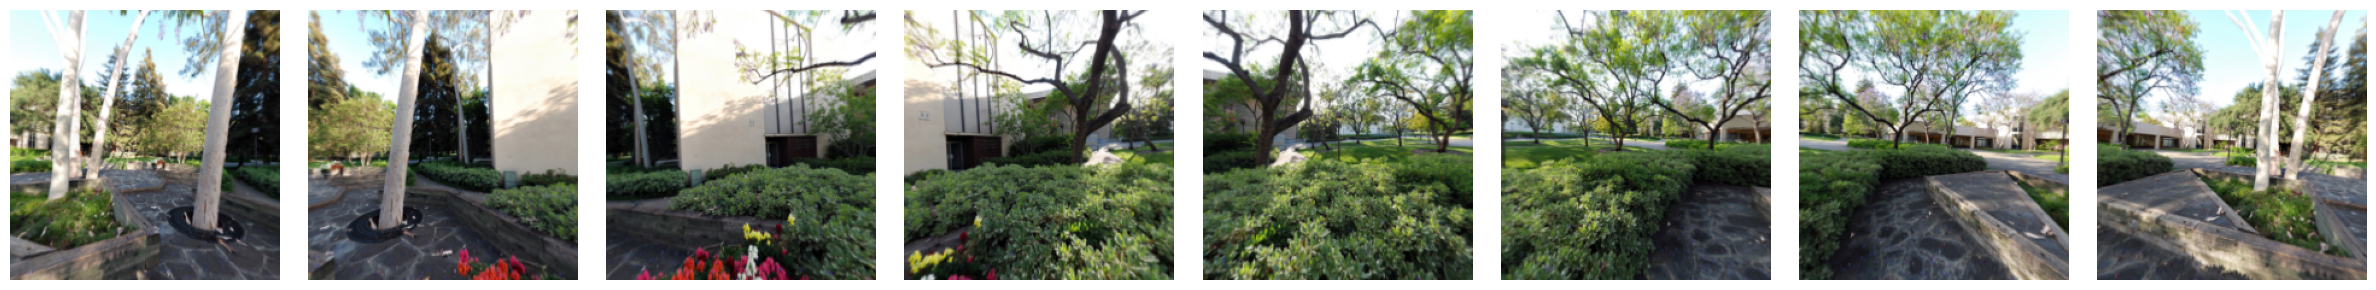

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [9]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from src.utils import visualize_tensor_batch
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer
import torch
import numpy as np

processor = AutoProcessor.from_pretrained("facebook/dinov2-small")
print(processor)
tokenzier = AutoTokenizer.from_pretrained("google/gemma-3-4b-it")
img = Image.open("data/quic360/downtest/images/540231919_58d07745aa_o.jpg").convert("RGB")
img = img.resize((224*4, 224*2), Image.BILINEAR)
img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # (1, C, H2, W4)
dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= processor,
    tokenizer=tokenzier,
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
imgs = dataset.crop_equirectangular_tensor(img_tensor)
visualize_tensor_batch(imgs)
sample = processor(images=imgs, return_tensors="pt")
model = AutoModel.from_pretrained('facebook/dinov2-small',cache_dir='./.cache')
outputs = model(sample['pixel_values'])
last_hidden_states = outputs.last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()  

### 제안하는 SurroundBlip 시각화

In [11]:
from src.models.surroundblip import SurroundBlip
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer

dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b",cache_dir='./.cache'),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]

model = SurroundBlip.from_pretrained("Salesforce/blip2-opt-2.7b", cache_dir='./.cache')
model = model.vision_model
model.eval()

last_hidden_states = model(sample['pixel_values']).last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
street <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

This is a sidewalk near a large intersection in a commercial district of a city.  There are large trucks, a bus, and several cars waiting at a red traffic light.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `BlipImageProcessor.preprocess` and were ignored: 'do_center_crop'
  return self.preprocess(images, **kwargs)


init_ query_tokens torch.Size([1, 32, 768])


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


In [ ]:
import os
# 사용할 GPU 번호 지정 (export CUDA_VISIBLE_DEVICES=1 과 동일)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from src.models.surroundblip import SurroundBlip
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer

dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b",cache_dir='./.cache'),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]

model = SurroundBlip.from_pretrained(
    pretrained_model_name_or_path = "checkpoints/blip2_vicregloss",
    local_files_only=True  # 로컬 파일만 사용하도록 강제
)
model = model.vision_model
model.eval()

last_hidden_states = model(sample['pixel_values']).last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()

/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
street <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

This is a sidewalk near a large intersection in a commercial district of a city.  There are large trucks, a bus, and several cars waiting at a red traffic light.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `BlipImageProcessor.preprocess` and were ignored: 'do_center_crop'
  return self.preprocess(images, **kwargs)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 11.80it/s]
Some weights of the model checkpoint at checkpoints/blip2_vicregloss were not used when initializing SurroundBlip: ['itm_head.bias', 'itm_head.weight', 'tau']
- This IS expected if you are initializing SurroundBlip from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertF

In [3]:
print(last_hidden_states.shape)  # Should print (batch_size, sequence_length, hidden_size)

(8, 257, 1408)


### 시각화

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian):
  Pair 0: MSE=1.0411, Cosine=0.2905, CKA=0.5779, Hung=0.6642
  Pair 1: MSE=1.1108, Cosine=0.2672, CKA=0.5816, Hung=0.6896
  Pair 2: MSE=1.0200, Cosine=0.3125, CKA=0.6543, Hung=0.7090
  Pair 3: MSE=1.0332, Cosine=0.3184, CKA=0.6234, Hung=0.7156
  Pair 4: MSE=1.0082, Cosine=0.2898, CKA=0.5951, Hung=0.6636
  Pair 5: MSE=1.0471, Cosine=0.3142, CKA=0.5853, Hung=0.6688
  Pair 6: MSE=0.9789, Cosine=0.3780, CKA=0.6308, Hung=0.7228
  Pair 7: MSE=0.9608, Cosine=0.3452, CKA=0.6356, Hung=0.7226
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x3x1). Calculated output size: (64x1x0). Output size is too small
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x3x1). Calculated output size: (64x1x0). Output size is too small
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x3x1). Calculated output size: (64x1x0). Output size is too small
⚠️ LPIPS

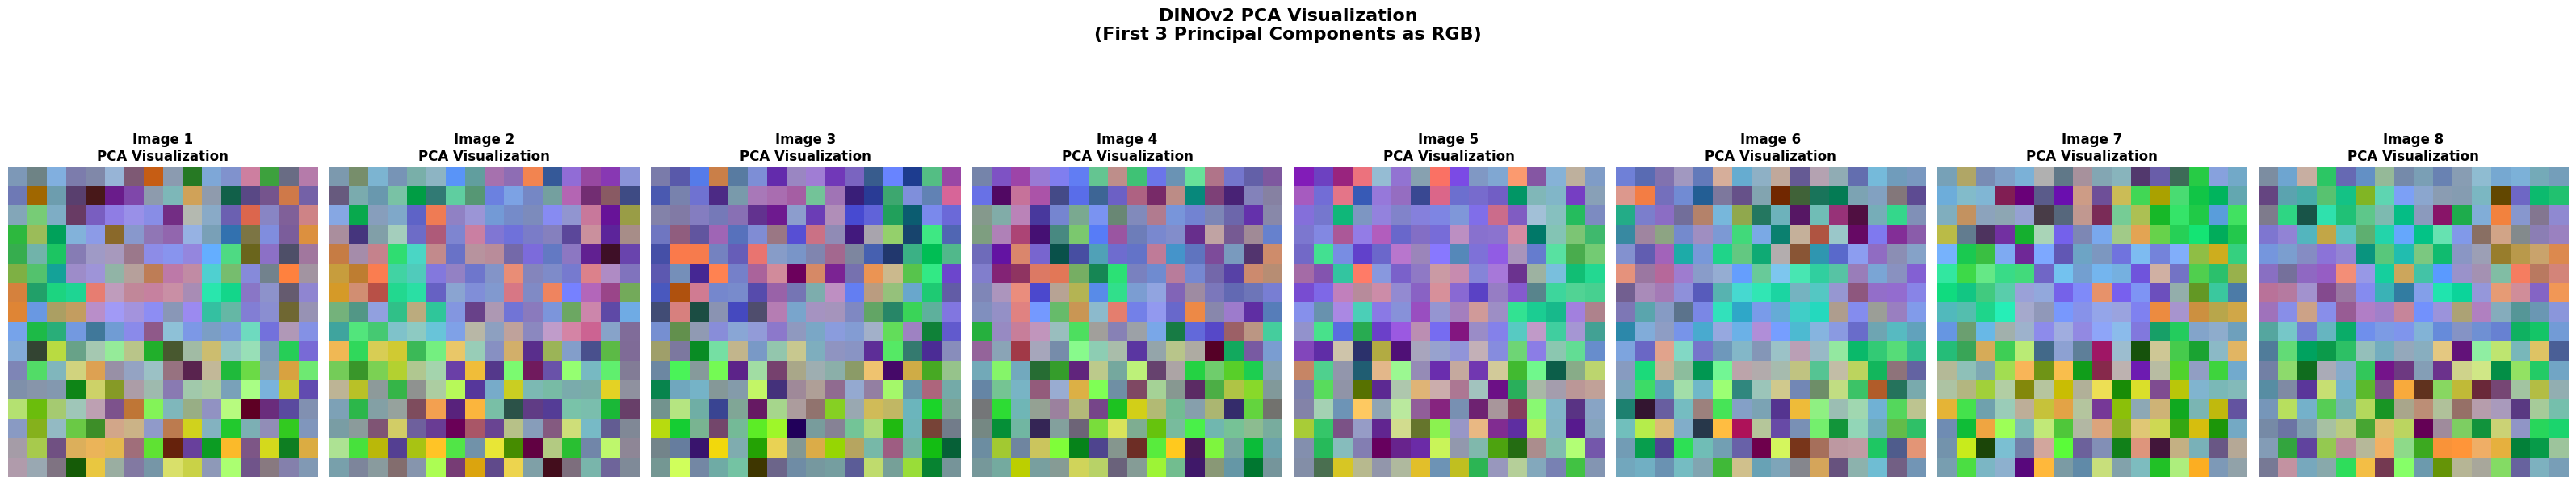


=== PCA 분석 결과 ===
주성분 1 설명 분산: 15.67%
주성분 2 설명 분산: 6.52%
주성분 3 설명 분산: 5.92%
총 설명 분산: 28.10%


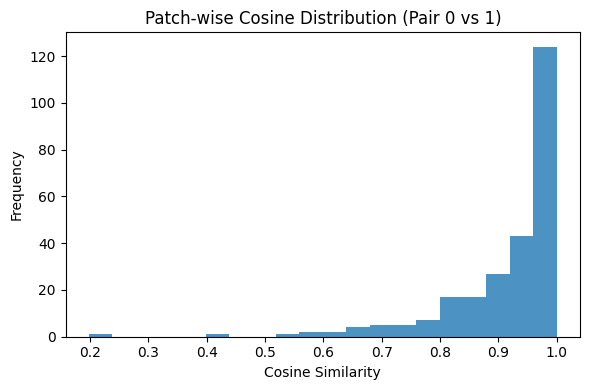

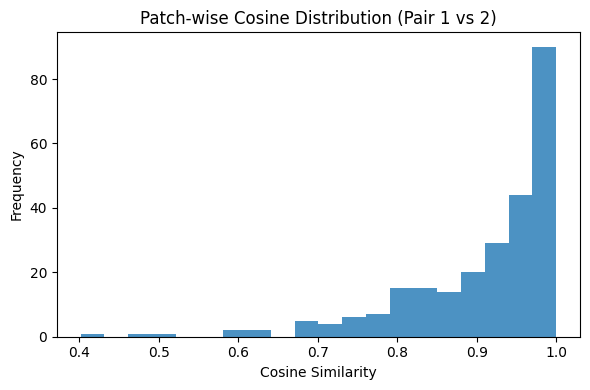

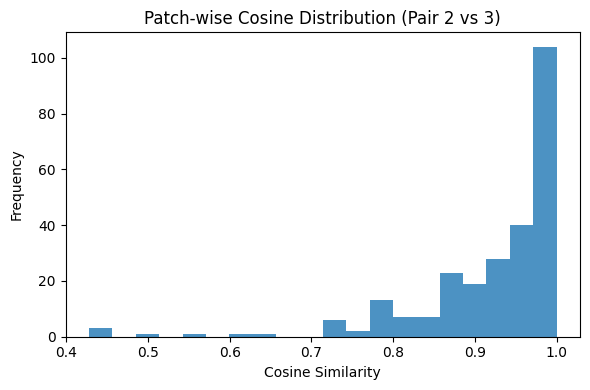

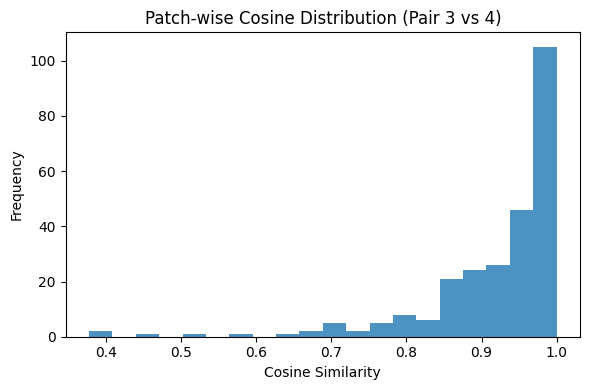

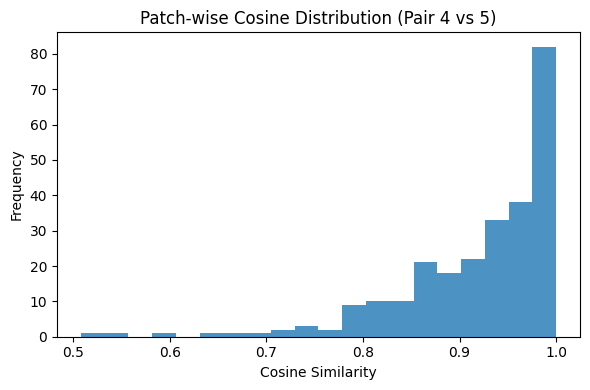

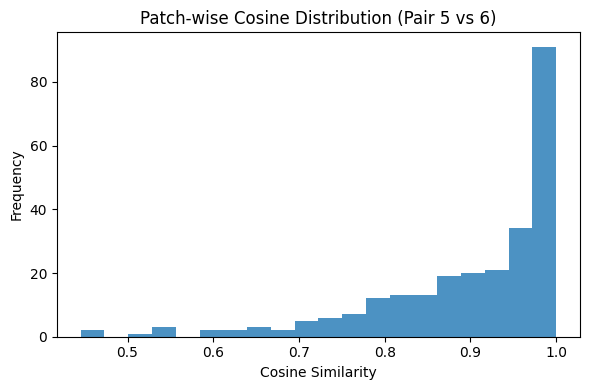

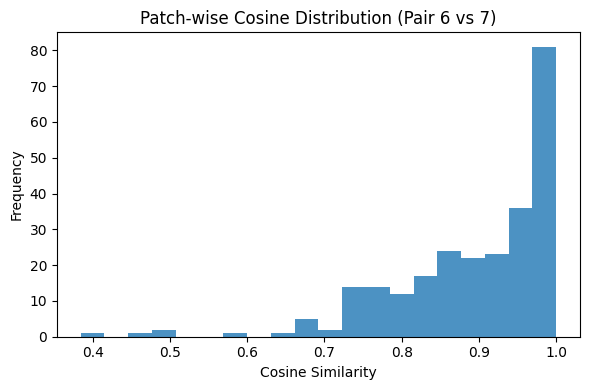

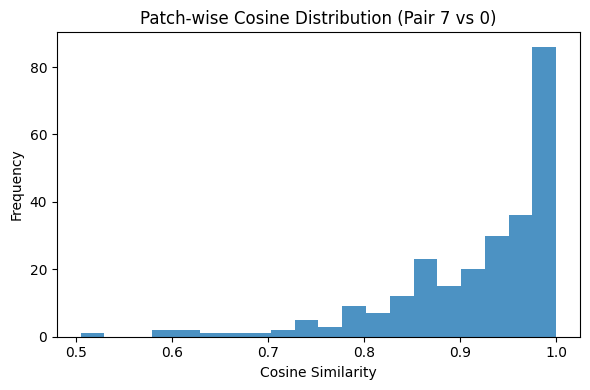

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# 기존 linear_cka 대신 아래를 사용
from sklearn.metrics.pairwise import rbf_kernel

def dinov2_multiple_pca_visualization(hidden_states_list, remove_cls_token=True, use_background_removal=True):
    """
    여러 이미지의 DINOv2 hidden states에서 공통 PCA 기반 RGB 시각화 생성
    
    Args:
        hidden_states_list (list): Hidden states 리스트 
                                  각 원소는 [seq_len, hidden_dim] 또는 [batch_size, seq_len, hidden_dim]
        remove_cls_token (bool): CLS 토큰 제거 여부
        use_background_removal (bool): 배경 제거 적용 여부
        
    Returns:
        list: RGB 시각화 이미지들의 리스트 [patch_h, patch_w, 3]
    """
    
    # 1. 모든 hidden states 전처리
    all_patch_tokens = []
    processed_tokens_list = []
    
    for hidden_states in hidden_states_list:
        # 배치 차원 처리
        if hidden_states.ndim == 3:
            hidden_states = hidden_states[0]
        
        # CLS 토큰 제거
        if remove_cls_token:
            patch_tokens = hidden_states[1:]
        else:
            patch_tokens = hidden_states
        
        processed_tokens_list.append(patch_tokens)
        all_patch_tokens.append(patch_tokens)
    
    # 2. 모든 패치 토큰 결합 (공통 PCA를 위해)
    combined_tokens = np.vstack(all_patch_tokens)
    
    # 3. 배경 제거 (선택적)
    if use_background_removal:
        # 1차 PCA로 배경/전경 분리
        pca_bg = PCA(n_components=1)
        bg_component = pca_bg.fit_transform(combined_tokens)
        
        # 경험적 임계값으로 전경 마스크 생성
        foreground_mask = bg_component.flatten() > 0.6
        
        if np.sum(foreground_mask) > 0:
            foreground_tokens = combined_tokens[foreground_mask]
        else:
            foreground_tokens = combined_tokens
    else:
        foreground_tokens = combined_tokens
    
    # 4. 공통 PCA 모델 학습 (첫 3개 성분)
    pca_semantic = PCA(n_components=3)
    pca_semantic.fit(foreground_tokens)
    
    # 5. 각 이미지별로 PCA 변환 및 RGB 시각화 생성
    pca_rgb_list = []
    
    for patch_tokens in processed_tokens_list:
        # 공통 PCA 모델로 변환
        semantic_features = pca_semantic.transform(patch_tokens)
        
        # RGB 정규화 [0, 1]
        rgb_features = np.zeros_like(semantic_features)
        for i in range(3):
            component = semantic_features[:, i]
            min_val, max_val = component.min(), component.max()
            if max_val != min_val:
                rgb_features[:, i] = (component - min_val) / (max_val - min_val)
            else:
                rgb_features[:, i] = 0.5
        
        # 패치 격자로 재구성
        num_patches = len(patch_tokens)
        patch_size = int(np.sqrt(num_patches))
        
        pca_rgb = rgb_features.reshape(patch_size, patch_size, 3)

        pca_rgb_list.append(pca_rgb)
    
    return pca_rgb_list, pca_semantic

from skimage.metrics import structural_similarity as ssim
import torch
import lpips
from scipy.optimize import linear_sum_assignment

# ──────────────────────────────────────────────────────────────────────────────
# 1) 토큰 유사도 보조 함수
# ──────────────────────────────────────────────────────────────────────────────
def token_cosine(A, B):
    num = np.sum(A * B, axis=-1)
    den = np.linalg.norm(A, axis=-1) * np.linalg.norm(B, axis=-1) + 1e-8
    return float(np.mean(num / den))

def hungarian_cosine(A, B):
    sim_mat = (A @ B.T) / (
        (np.linalg.norm(A, axis=1)[:,None] * np.linalg.norm(B, axis=1)[None]) + 1e-8
    )
    row, col = linear_sum_assignment(-sim_mat)
    return float(sim_mat[row, col].mean())

def linear_cka(A, B):
    """
    CKA 유사도. A, B는 각각 (N, D) 형태의 행렬.
    반환값이 클수록 유사.
    """
    # Gram matrix 계산
    gram_A = A @ A.T
    gram_B = B @ B.T
    
    # CKA 계산
    cka = np.sum(gram_A * gram_B) / np.sqrt(np.sum(gram_A**2) * np.sum(gram_B**2))
    
    return float(cka)

# ──────────────────────────────────────────────────────────────────────────────
# 2) 이미지(3채널) 유사도 보조 함수
# ──────────────────────────────────────────────────────────────────────────────
_lpips = lpips.LPIPS(net='alex').to('cpu')
def rgb_ssim(A, B):
    return float(ssim(A, B, channel_axis=-1, data_range=1.0))

def rgb_lpips(A: np.ndarray, B: np.ndarray) -> float:
    """
    LPIPS 유사도. 입력이 너무 작아 LPIPS 연산에 실패하면 SSIM 값으로 대체.
    반환값이 클수록 유사.
    """
    # SSIM fallback 함수
    def _ssim_fallback():
        from skimage.metrics import structural_similarity as _ssim
        return float(_ssim(A, B, channel_axis=-1, data_range=1.0))
    
    if _lpips is None:
        # LPIPS 모델이 준비되지 않은 경우
        return _ssim_fallback()
    
    # 텐서 변환
    a = torch.from_numpy(A).permute(2,0,1)[None].float() * 2 - 1  # [0,1]→[-1,1]
    b = torch.from_numpy(B).permute(2,0,1)[None].float() * 2 - 1
    try:
        with torch.no_grad():
            d = _lpips(a, b)
        return -float(d.item())  # 거리→음수로 유사도화
    except RuntimeError as err:
        # LPIPS 내부 pooling 등에서 크기 오류 발생 시
        print("⚠️ LPIPS 연산 실패, SSIM으로 대체:", err)
        return _ssim_fallback()
    
def plot_patch_cosine_histograms(proc_tokens, pairs=None, bins=20):
    """
    proc_tokens: list of (h, w, D) 배열
    pairs: [(i, j), ...] 형태로 히스토그램을 그리고 싶은 쌍 인덱스. 
           None이면 (0,1), (1,2), ..., (N-1,0) 순서로 모두 그림.
    """
    N = len(proc_tokens)
    if pairs is None:
        pairs = [(i, (i+1)%N) for i in range(N)]
    
    for idx, (i, j) in enumerate(pairs):
        A = proc_tokens[i].reshape(-1, proc_tokens[i].shape[-1])
        B = proc_tokens[j].reshape(-1, proc_tokens[j].shape[-1])
        cos_patch = np.sum(A * B, axis=1) / (
            np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1) + 1e-8
        )
        
        plt.figure(figsize=(6,4))
        plt.hist(cos_patch, bins=bins, alpha=0.8)
        plt.title(f'Patch-wise Cosine Distribution (Pair {i} vs {j})')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
# ──────────────────────────────────────────────────────────────────────────────
# 수정된 hidden_similarity
# ──────────────────────────────────────────────────────────────────────────────
def hidden_similarity(hidden_states_list):
    processed = []
    for hs in hidden_states_list:
        if hs.ndim == 3: hs = hs[0]
        pt = hs[1:] if hs.shape[0]>1 else hs
        h = int(np.sqrt(pt.shape[0])); w=h
        processed.append(pt.reshape(h,w,-1))
    
    sim_mse, sim_cosine, sim_cka, sim_hungarian = [], [], [], []
    half = processed[0].shape[0]//2
    for i in range(len(processed)):
        A = processed[i][:, half:, :].reshape(-1, processed[i].shape[-1])
        B = (
            processed[i+1] if i+1<len(processed) else processed[0]
        )[:, :half, :].reshape(-1, processed[i].shape[-1])
        
        sim_mse.append( np.mean((A-B)**2) )
        sim_cosine.append( token_cosine(A, B) )
        sim_cka.append( linear_cka(A, B) )
        sim_hungarian.append( hungarian_cosine(A, B) )
    
    print("▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian):")
    for i,(m,c,k,hg) in enumerate(zip(sim_mse,sim_cosine,sim_cka,sim_hungarian)):
        print(f"  Pair {i}: MSE={m:.4f}, Cosine={c:.4f}, CKA={k:.4f}, Hung={hg:.4f}")

# ──────────────────────────────────────────────────────────────────────────────
# 수정된 pca_similarity
# ──────────────────────────────────────────────────────────────────────────────
def pca_similarity(pca_rgb_list):
    sim_mse, sim_ssim, sim_lpips = [], [], []
    half = pca_rgb_list[0].shape[0]//2
    for i in range(len(pca_rgb_list)):
        A = pca_rgb_list[i][:, :half, :]
        B = pca_rgb_list[i+1] if i+1<len(pca_rgb_list) else pca_rgb_list[0]
        B = B[:, :half, :]
        
        sim_mse.append( np.mean((A-B)**2) )
        sim_ssim.append( rgb_ssim(A, B) )
        sim_lpips.append( rgb_lpips(A, B) )
    
    print("▶ PCA-RGB 유사도 (MSE, SSIM, LPIPS):")
    for i,(m,s,l) in enumerate(zip(sim_mse,sim_ssim,sim_lpips)):
        print(f"  Pair {i}: MSE={m:.4f}, SSIM={s:.4f}, LPIPS={l:.4f}")
    return sim_mse  # 기존 리턴 형태 유지

def visualize_multiple_pca_results(hidden_states_list, titles=None, save_path=None, figsize=None):
    """
    여러 이미지의 PCA 결과를 동시에 시각화 (DINOv2 논문 Figure 1 스타일)
    
    Args:
        hidden_states_list (list): Hidden states 리스트
        titles (list, optional): 각 이미지의 제목
        save_path (str, optional): 저장 경로
        figsize (tuple, optional): 그림 크기
        
    Returns:
        tuple: (pca_rgb_list, pca_model)
    """
    
    num_images = len(hidden_states_list)
    
    # 기본 설정
    if titles is None:
        titles = [f'Image {i+1}' for i in range(num_images)]
    
    if figsize is None:
        figsize = (4 * num_images, 8)
    
    # PCA 수행
    hidden_similarity(hidden_states_list)
    
    pca_rgb_list, pca_model = dinov2_multiple_pca_visualization(hidden_states_list)
    
    # 시각화
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    pca_similarity(pca_rgb_list)
    # 단일 이미지인 경우 axes를 리스트로 변환
    if num_images == 1:
        axes = [axes]
    
    for i, (pca_rgb, title) in enumerate(zip(pca_rgb_list, titles)):
        axes[i].imshow(pca_rgb)
        axes[i].set_title(f'{title}\nPCA Visualization', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('DINOv2 PCA Visualization\n(First 3 Principal Components as RGB)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"시각화 저장: {save_path}")
    
    plt.show()
    
    # PCA 분석 정보 출력
    explained_variance = pca_model.explained_variance_ratio_
    print(f"\n=== PCA 분석 결과 ===")
    print(f"주성분 1 설명 분산: {explained_variance[0]:.2%}")
    print(f"주성분 2 설명 분산: {explained_variance[1]:.2%}")
    print(f"주성분 3 설명 분산: {explained_variance[2]:.2%}")
    print(f"총 설명 분산: {np.sum(explained_variance):.2%}")
    
    return pca_rgb_list, pca_model

hidden_states_list = last_hidden_states
pca_results, pca_model = visualize_multiple_pca_results(
    hidden_states_list, 
)
plot_patch_cosine_histograms(pca_results)
